# Basic Hypothetical Gait Detection for Mobile Exoskeleton

This notebook illustrates a simple method of detecting what kind of motion a person is performing (walking, running, etc.) based on some basic force data.

---

## Motivation

I used to be on uOttawa Bionics, a student engineering team trying to build a hip-mounted exoskeleton for rehabilitation. A huge problem we faced was how the suit would know how it needs to move to help the person walk. I never got around to tackling this when on the team, so I figured I'd try my hand at it now.

There are a few ways which I know of for going about this. The simplest is to have the suit pre-programmed to move in a certain way; it'll walk at a certain speed when a Walk button is pressed, sit down at a certain rate and into a certain position when the Sit button is pressed, etc. While programming this is certainly more simple than other approaches, it's not great for a wearer who wants control of their actions. Perhap a pre-programmed walking style makes sense in the context of rehabilitation, where it might help re-teach proper gait, but what about in construction, or the military, or just wearing an exoskeleton for fun, where we want wearing an exoskeleton to feel like an extension of ourselves and not something which limits us?

The more complicated approach is to have the suit work with the wearer and augment their desired motion. This means, however, that the suit must know what the wearer is trying to do. This might include:

1. what kind of gait are they using (walking, running, kneeling, sitting, etc.)
2. Where are they in that particular gait cycle (beginning their stride, transfering weight to the other leg, etc.), and
3. Probably many more questions I didn't bother tackling here.

This notebook is my attempt at implemnenting the latter; a super basic way of detecting what the user is trying to do, and guessing what they'll try to do next.

I chose to do this mini-project in Julia since I've heard interesting things about it and wanted to give it a shot.

---

## Generating Data

Before we can go ahead and detect what kind of gait someone is performing and where in the gait cycle they are, we need some data to work with. I don't exactly have access to force sensors and a plethora of willing volunteers anymore, so instead we'll nab some lazy data from a paper; in this case, I chose the normalized hip moment for running and walking from Figure 1 B from *Motor Patterns in Human Walking and Running* (available [here](https://journals.physiology.org/doi/full/10.1152/jn.00081.2006)). Since the dataset isn't provided, I used [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) to turn each subplot into a `.csv` file.

In [1]:
using DelimitedFiles, Polynomials, Plots

In [2]:
walkingdata = readdlm("hip-torque-walking-extracted.csv", ',', Float64)
runningdata = readdlm("hip-torque-running-extracted.csv", ',', Float64)

42×2 Matrix{Float64}:
 0.0125084   0.636792
 0.0374541   0.630602
 0.0635576   0.612018
 0.0806792   0.763792
 0.0992604   0.969649
 0.110907    1.18373
 0.129733    1.23711
 0.152078    1.07644
 0.166976    0.855855
 0.175718    0.675467
 0.192992    0.516382
 0.215758    0.451086
 0.244598    0.43464
 ⋮          
 0.72297    -0.182758
 0.746178    0.0173687
 0.765705    0.169772
 0.786095    0.305061
 0.815507    0.384429
 0.843294    0.37885
 0.871082    0.388613
 0.898869    0.438127
 0.927499    0.525241
 0.954024    0.574144
 0.982232    0.515535
 0.998652    0.417205

We have some data, but it's not enough; a quick DDG search shows that force transducers like [this one](https://aurorascientific.com/products/muscle-physiology/force-transducers/) can read at up to $4kHz$ - up to 4000 times per second. I got about 70 readings for the walking data and 40 for the running data.
In order to create more data to mimic the reading frequency of a force transducer, we'll curve fit our not-so-great data with a polynomial fit, then use that polynomial fit to populate 4000 data points per second.

### Creating a Polynomial Fit

For those that have forgotten (namely, me before doing this), a polynomial function takes the form ($y(x) = a_1 x^1 + a_2 x^2 + \cdots + a_n x^n$). The higher the order of the polynomial ($n$), the closer the function will fit our data. If we choose too high of an order though, the function will fit it too well; if the data used to fit is imperfect (which ours really is since I manually generated the data using WebPlotDigitizer), then the polynomial fit also becomes imperfect. You can see some graphs showing this effect [here](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765).

We can create the polynomial fit using the `Polynomials.jl` package and use `Plots.jl` to compare the fits to the original data. Messing around with different orders of polynomial, I found that $n = 15$ was suitable for the walking data and $n = 13$ was suitable for the running data; any higher for the latter introduced spikes to the polynomial fit. I assume this is because the running data set had less points to it, resulting in a rockier fit. In any case, this isn't super significant; the data I extracted using WebPlotDigitizer is already inaccurate, so a bit more inaccuracy won't hurt.

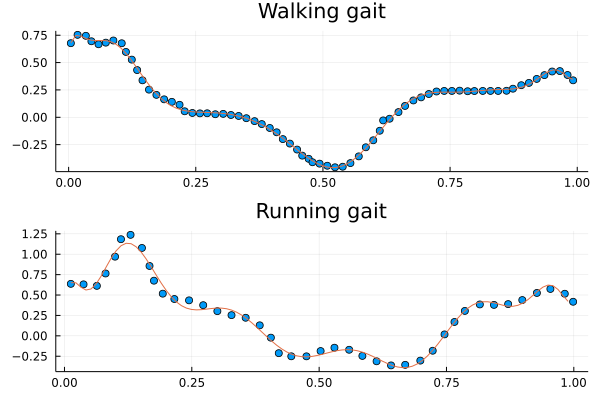

In [3]:
walkingfit = fit(walkingdata[:,1], walkingdata[:,2], 15)
runningfit = fit(runningdata[:,1], runningdata[:,2], 13)

walkingdataplot = plot(walkingdata[:,1], walkingdata[:,2], seriestype = :scatter, title = "Walking gait", label="Raw Data")
# update specified plot using !
# walking fit is a function, which is applied from the smallest
# value in x to the largest (the extremes found using extrema)
# ... here tells plots to fill in the blanks (I think) between extremes
walkingfitplot = plot!(walkingdataplot, walkingfit, extrema(walkingdata[:,1])..., label="Polynomial fit")
# repeat with running data
runningdataplot = plot(runningdata[:,1], runningdata[:,2], seriestype = :scatter, title = "Running gait", label="Raw Data")
runningfitplot = plot!(runningdataplot, runningfit, extrema(runningdata[:,1])..., label="Polynomial fit")
# two plots, stacked
plot(walkingdataplot, runningdataplot, layout = (2,1), legend = false)

### Creating More Data

Now that we have polynomial fits which approximate each (way too small) set of data, it's time to create more dense sets of data; to get closer to that 4000-readings-per-second from real force transducers. To do so, we need to know how long a single stride takes; the Figure from the paper is from 0 to 1, where 0 is the beginning of a stride and 1 is the end of that stride (getting back to the starting position), but we don't know if 1 is a second or twenty.

In the spirit of keeping this little project as sketchy as possible, I'll use some very trustworthy and absolutely not random internet sources for my data. According to [Science Trends](https://sciencetrends.com/how-many-steps-are-in-one-mile-body-size-and-walking-vs-running/), it takes about 2250 steps to walk a mile and 1550 steps to run a mile. The average [walking speed](https://www.healthline.com/health/exercise-fitness/average-walking-speed) is about 3.5 miles per hour, or an average of:

$$\frac{1\,\textrm{hour}}{3.5\,\textrm{miles}} \times \frac{3600\,\textrm{seconds}}{\textrm{hour}} \approx \frac{1029\,\textrm{seconds}}{\textrm{mile}}$$

To find the number of seconds per step, we can do:

$$\frac{1029\,\textrm{seconds}}{\textrm{mile}} \times \frac{1\,\textrm{mile}}{2250\,\textrm{steps}} \approx \frac{0.457\,\textrm{seconds}}{\textrm{step}}$$

We can repeat this calculation for running, which, with an [average pace](https://www.healthline.com/health/fitness-exercise/average-running-speed) of $\frac{9\,\textrm{minutes}}{\textrm{mile}}$:

$$\frac{9\,\textrm{minutes}}{\textrm{mile}} \times \frac{60\,\textrm{seconds}}{\textrm{minute}} \times \frac{1\,\textrm{mile}}{1550\,\textrm{steps}} \approx \frac{0.348\,\textrm{seconds}}{\textrm{step}}$$

We can now figure out how many samples should be in each set of data. For walking:

$$\frac{4000\,\textrm{samples}}{\textrm{second}} \times \frac{0.457\,\textrm{seconds}}{\textrm{step}} = \frac{1828\,\textrm{samples}}{\textrm{step}}$$

Likewise for running:

$$\frac{4000\,\textrm{samples}}{\textrm{second}} \times \frac{0.348\,\textrm{seconds}}{\textrm{step}} = \frac{1392\,\textrm{samples}}{\textrm{step}}$$

Now, was any of this strictly necessary? I suppose I could have just used 4000 values for both the running and walking data sets, but I figured I'd at least pretend to science properly. That, and having calculations in my notebook might give the illusion that I have any idea what I'm doing.

Now that we have the number of values we need in the data set for each gait, we can create the sets.

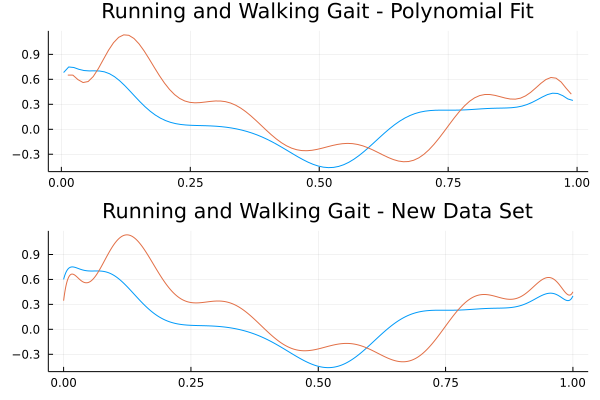

In [17]:
# collect is similar to range() in python
# we're going from 0 to 1828 in steps of 1 (giving )
walkingxrange = range(0, stop = 1, length = 1828)
runningxrange = range(0, stop = 1, length = 1392)

walkingyrange = map(walkingfit, walkingxrange)
runningyrange = map(runningfit, runningxrange)

# Fit data from above
walkingfitplot = plot(walkingfit, extrema(walkingdata[:,1])..., title = "Running and Walking Gait - Polynomial Fit")
runningfitplot = plot!(walkingfitplot, runningfit, extrema(runningdata[:,1])...,)

# Plot using desired number of values per data set
walkingplot = plot(walkingxrange, walkingyrange, title = "Running and Walking Gait - New Data Set", label = "Walking")
runningplot = plot!(runningxrange, runningyrange, label="Running")

plot(runningfitplot, walkingplot, layout = (2,1), legend = false)

Looks like it worked, the curves have the same shapes and magnitudes.! Now that we have reasonably detailed sets of data to work with, we can try our method for finding the type of gait and where we are in the gait cycle.

## Predicting Gait using the Root Mean Square Error

This is the simplest (but hardly most efficient) method I can think of to figure out what the current gait is, and where we are in that gait cycle. Our solution follows these steps:

1. Grab the last $n$ values of the force transducer
2. Iterate over our gait data for both walking and running. At every step, calculate the Root Mean Square Error (RMSE) between our data readings and the current gait values
3. Choose the gait data which gave the lowest error; this is likely where we are in the gait cycle

### What Should our Sample Size Be?

Unfortunately, it's tough to know what the sample size (the last $n$ readings) should be in advance.
If $n$ is too high, then we're looking too far into the past and might use values which belong to a different type of gait. As an extreme example, if we look at the last minute of gait data, there might be running, walking, sitting, squatting, and a bunch of other things happening in that time span, so whatever we're likely to guess is **currently** happening is likely to be wrong.
If $n$ too low, then we might accidentally guess the wrong gait, since a small sample might match a pattern that is found in multiple types of gaits. An extreme example in this case would be taking a single value, perhaps 0N of force. This might appear when sitting on a chair (since the suit isn't doing anything) or while walking and letting gravity swing the leg; with only a single sample of 0N, we have no way of knowing which it is.
I get the impression that choosing a proper $n$ would require some experimentation with actual sensors and patients, so for now, I'll just pick a value more or less at random.
Having thoroughly butchered any semblence of the scientific process, we can now proceed to implement the little algorithm above.

In [6]:
# arrays which will hold the root mean square error of each step
walkingrmserange = fill(0.0, (1,length(walkingyrange)))
runningrmserange = fill(0.0, (1,length(runningyrange)))

# STEP 1: Grab the last n readings from the force transducer
# here, I've chosen n values from our range of y values,
# creating a set of hypothetical data to find the nearest match to
n = 4
samplestartpoint = 1821
sampledata = walkingyrange[samplestartpoint:samplestartpoint+n-1]
correctindex = samplestartpoint+n
correctvalue = walkingyrange[samplestartpoint+n]

# add the first n-1 values to the end of the array, since we need to calculate the RMSE
# for the last actual step, which will need n-1 more values after it to calculate
for i = 1:n-1
    push!(walkingyrange,walkingyrange[i])
    push!(runningyrange,runningyrange[i])
end

# STEP 2: iterate over gait data for walking and running and calculate RMSE for each step
# walking
for i = 1:length(walkingrmserange)
    steppartialerror = 0
    # iterate over the n elements starting at the current step i and calculate interior of RMSE
    for j = 1:n
        # sampled value minus value from data set, squared to give consistent sign
       steppartialerror =  steppartialerror + (sampledata[j] - walkingyrange[i+j-1])^2
    end
    walkingrmserange[i] = sqrt(steppartialerror / n)
end
# running
for i = 1:length(runningrmserange)
    steppartialerror = 0
    # iterate over the n elements starting at the urrent step i and calculate interior of RMSE
    for j = 1:n
        # sampled value minus value from data set, squared to give consistent sign
       steppartialerror =  steppartialerror + (sampledata[j] - runningyrange[i+j-1])^2
    end
    runningrmserange[i] = sqrt(steppartialerror / n)
end

# STEP 3: choose the gait data which gave the lowest RMSE
# walkingrmsemin and runningrmsemin are tuples containing the minimum RMSE [1] and 
# its index [2]
walkingrmsemin = findmin(walkingrmserange)
runningrmsemin = findmin(runningrmserange)

# Choosing the next value requires a bit of thinking; lets say we calculated the RMSE at index i.
# In reality, the furthest index in time we checked is at index i+(n-1)
# Therefore, the next point won't be the index after i (i+1), but rather (i+(n-1))+1 == i+n

nextvalue = 0
nextindex = 0

if walkingrmsemin[1] < runningrmsemin[1]
    println("Walking")
    nextvalue = walkingyrange[walkingrmsemin[2][2] + n]
    nextindex = walkingrmsemin[2][2] + n
else
    println("Running")
    nextvalue = runningyrange[runningrmsemin[2][2] + n]
    nextindex = runningrmsemin[2][2] + n
end

print("Correct next index:\t")
print(correctindex)
print("\nOur next index:\t\t")
print(nextindex)
print("\nCorrect next answer:\t")
print(correctvalue)
print("\nOur next answer:\t")
print(nextvalue)
print("\nSample data:\t\t")
print(sampledata)
print("\nOur data:\t\t")
print(walkingyrange[nextindex-n:nextindex-1])

Walking
Correct next index:	1825
Our next index:		1825
Correct next answer:	0.38174229182127134
Our next answer:	0.38174229182127134
Sample data:		[0.3630481397967631, 0.3669692800886787, 0.371374678614063, 0.3762900269749638]
Our data:		[0.3630481397967631, 0.3669692800886787, 0.371374678614063, 0.3762900269749638]

## What Next?

So now we have a super basic method for detecting current gait. I'm absolutely positive no exoskeletons out there use this, but it was a cute little exercise. That said, what could we do to improve our approach?
One idea is to improve the performance of our algorithm. While the method above works, it isn't the fastest algorithm in the world; it must iterate over the full arrays for each gait type to find the point with the lowest RMSE. Once those arrays grow, this method will become less efficient. O(N) scaling is pretty good, but getting to logarithmic complexity (O(log(N))) using something like a hash map would be nice; the hypothetical performance gain illustrated below is pretty massive:

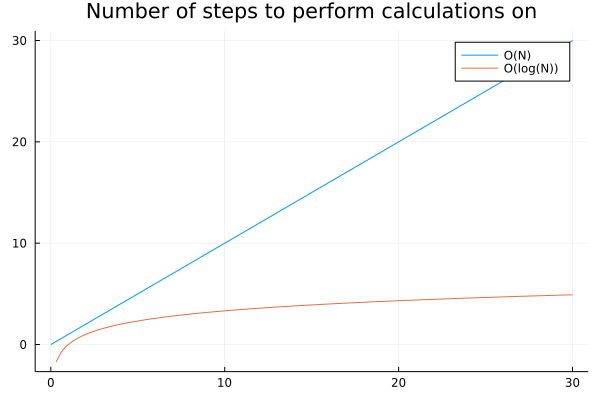

In [7]:
xrange = range(0, stop = 30, length = 100)
plot(xrange, xrange, title = "Number of steps to perform calculations on", label = "O(N)")
# the period after log2 applies it to each element
plot!(xrange, log2.(xrange), label = "O(log(N))")

This could be pretty significant when it comes to deploying our algorithm to actual hardware. The longer it takes for our code to predict the user's next move, the more expensive hardware must be used to get the desired performance, or the worse the performance of the suit, such as reducing $n$ or the rate at which our predictions are made. The latter is dangerous, because if it takes too long for our code to figure out the next step, it'll lag behind the wearer, who'll notice that they're fighting to suit instead of it working with them seamlessly.

## Fin?

I'm about to start a school semester, so I don't think I'll be able to circle back around to this for a while. If you have any questions though, feel free to send me an email :)